<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/General%20Helpers/PyTorch/Experiments/PyTorch_transfer_learning_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4097, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 4097 (delta 33), reused 56 (delta 19), pack-reused 4009 (from 1)
Receiving objects: 100% (4097/4097), 650.79 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


## 1. Get the data

In [4]:
from math import e
import os
import zipfile

from pathlib import Path
import requests

# setup path to data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} directory exists.')
else:
    print(f'Did not find {image_path} directory!')
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip the file
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # remove .zip file
    os.remove(data_path / 'pizza_steak_sushi.zip')

Did not find data/pizza_steak_sushi directory!
Unzipping pizza, steak, sushi data...


In [5]:
# Setup Dirs
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for torchvision.models (manual creation)

* All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least 224**.

* The mean and standard deviation must to be
```transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])``` because it will be the same distribution to pretrained model

In [6]:
manual_transform = transforms.Compose([transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
                                       transforms.ToTensor(), # 2. Turn image values to between 0 & 1
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                                                            std=[0.229, 0.224, 0.225])]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               manual_transform,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78d4ee1a6f80>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models (auto creation)

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT # # .DEFAULT = best available weights

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               auto_transforms,
                                                                               batch_size=32)


train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78d4e7e4c670>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

### 3.1 Setting up a pretrained model

In [11]:
# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 43.7MB/s]


In [12]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24, 112

### 3.2 Freezing the base model and changing the output layer to suit our needs

* Let's now adjust the output layer or the classifier portion of our pretrained model to our needs.

* Right now our pretrained model has out_features=1000 because there are 1000 classes in ImageNet.

* However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

In [13]:
# Freeze all of the base layers in EffNetV2
for param in model.features.parameters():
    param.requires_grad = False

In [14]:
# the parameters will all be False, no trainable, only output layer is trainable
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 

In [15]:
# adjust the output of the pretrained model, only have 3 classes to predict, but this model orginal has 1000
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, # Sequential(classifier) Linear (1) [32, '1280'], above the summary
                    out_features=output_shape,
                    bias=True)).to(device)

In [16]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, input_size=(32, 3, 224, 224), verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 

## 4. Train Model

In [20]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [25]:
from typing import Dict, List, Tuple

import torch
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score
from typing import Dict, List, Tuple
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

class Trainer:
    """
    A class to encapsulate the training, testing, and evaluation of a PyTorch model.

    Attributes:
        model (torch.nn.Module): The PyTorch model to be trained and evaluated.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for testing data.
        optimizer (torch.optim.Optimizer): Optimizer used to update model weights.
        loss_fn (torch.nn.Module): Loss function used to calculate the error.
        device (torch.device): The device (CPU or GPU) on which computations are performed.
        num_classes (int): Number of classes in the classification task.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler (default is None).
        early_stopping_patience (int, optional): Number of epochs with no improvement after which training will be stopped (default is None).
    """

    def __init__(self,
                 model: torch.nn.Module,
                 train_dataloader: torch.utils.data.DataLoader,
                 test_dataloader: torch.utils.data.DataLoader,
                 optimizer: torch.optim.Optimizer,
                 loss_fn: torch.nn.Module,
                 device: torch.device,
                 num_classes: int,
                 scheduler: torch.optim.lr_scheduler._LRScheduler = None,
                 early_stopping_patience: int = None):
        """
        Initializes the Trainer class with the given model, data loaders, optimizer, loss function, and other training parameters.

        Args:
            model (torch.nn.Module): The PyTorch model to be trained and tested.
            train_dataloader (torch.utils.data.DataLoader): DataLoader instance for training data.
            test_dataloader (torch.utils.data.DataLoader): DataLoader instance for testing data.
            optimizer (torch.optim.Optimizer): Optimizer to update the model's parameters.
            loss_fn (torch.nn.Module): Loss function to minimize during training.
            device (torch.device): The device to perform computation on (e.g., 'cuda' or 'cpu').
            num_classes (int): Number of classes in the classification task.
            scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler to adjust the learning rate during training (default is None).
            early_stopping_patience (int, optional): Number of epochs with no improvement after which training stops (default is None).
        """
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.num_classes = num_classes
        self.scheduler = scheduler
        self.early_stopping_patience = early_stopping_patience

        # Initialize metrics using torchmetrics
        self.metrics = {
            "accuracy": Accuracy(task='multiclass', num_classes=num_classes).to(device),
            "precision": Precision(task='multiclass', num_classes=num_classes).to(device),
            "recall": Recall(task='multiclass', num_classes=num_classes).to(device),
            "f1": F1Score(task='multiclass', num_classes=num_classes).to(device)
        }

    def train_step(self) -> Tuple[float, Dict[str, float]]:
        """
        Trains the model for a single epoch using the training dataloader.

        Returns:
            Tuple[float, Dict[str, float]]: Returns the average training loss and a dictionary of computed metrics.
        """
        self.model.train()  # Set the model to training mode
        train_loss = 0
        metric_results = {name: 0 for name in self.metrics.keys()}

        # Iterate over batches of data
        for X, y in self.train_dataloader:
            X, y = X.to(self.device), y.to(self.device)
            y_pred = self.model(X)
            loss = self.loss_fn(y_pred, y)
            train_loss += loss.item()

            # Backpropagation and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Calculate metrics for this batch
            y_pred_class = torch.argmax(y_pred, dim=1)
            for name, metric in self.metrics.items():
                metric_results[name] += metric(y_pred_class, y).item()

        # Average the loss and metrics over all batches
        train_loss /= len(self.train_dataloader)
        metric_results = {name: total / len(self.train_dataloader) for name, total in metric_results.items()}
        return train_loss, metric_results

    def test_step(self) -> Tuple[float, Dict[str, float]]:
        """
        Tests the model for a single epoch using the testing dataloader.

        Returns:
            Tuple[float, Dict[str, float]]: Returns the average testing loss and a dictionary of computed metrics.
        """
        self.model.eval()  # Set the model to evaluation mode
        test_loss = 0
        metric_results = {name: 0 for name in self.metrics.keys()}

        # No gradients needed for evaluation
        with torch.inference_mode():
            for X, y in self.test_dataloader:
                X, y = X.to(self.device), y.to(self.device)
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)
                test_loss += loss.item()

                # Calculate metrics for this batch
                y_pred_class = torch.argmax(y_pred, dim=1)
                for name, metric in self.metrics.items():
                    metric_results[name] += metric(y_pred_class, y).item()

        # Average the loss and metrics over all batches
        test_loss /= len(self.test_dataloader)
        metric_results = {name: total / len(self.test_dataloader) for name, total in metric_results.items()}
        return test_loss, metric_results

    def train(self, epochs: int) -> Dict[str, List[float]]:
        """
        Trains the model over a specified number of epochs, with optional learning rate scheduling and early stopping.

        Args:
            epochs (int): Number of epochs to train the model for.

        Returns:
            Dict[str, List[float]]: A dictionary containing the training and testing loss and metrics for each epoch.
        """
        results = {"train_loss": [],
                   "train_acc": [],
                   "train_precision": [],
                   "train_recall": [],
                   "train_f1": [],
                   "test_loss": [],
                   "test_acc": [],
                   "test_precision": [],
                   "test_recall": [],
                   "test_f1": []}

        best_loss = float('inf')
        epochs_without_improvement = 0

        # Iterate over each epoch
        for epoch in tqdm(range(epochs)):
            train_loss, train_metrics = self.train_step()
            test_loss, test_metrics = self.test_step()

            # Print the metrics for this epoch
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_metrics['accuracy']:.4f} | "
                f"train_precision: {train_metrics['precision']:.4f} | "
                f"train_recall: {train_metrics['recall']:.4f} | "
                f"train_f1: {train_metrics['f1']:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_metrics['accuracy']:.4f} | "
                f"test_precision: {test_metrics['precision']:.4f} | "
                f"test_recall: {test_metrics['recall']:.4f} | "
                f"test_f1: {test_metrics['f1']:.4f}"
            )

            # Store the metrics in the results dictionary
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_metrics['accuracy'])
            results["train_precision"].append(train_metrics['precision'])
            results["train_recall"].append(train_metrics['recall'])
            results["train_f1"].append(train_metrics['f1'])
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_metrics['accuracy'])
            results["test_precision"].append(test_metrics['precision'])
            results["test_recall"].append(test_metrics['recall'])
            results["test_f1"].append(test_metrics['f1'])

            # Update the learning rate if scheduler is provided
            if self.scheduler:
                self.scheduler.step(test_loss)

            # Implement early stopping
            if self.early_stopping_patience:
                if test_loss < best_loss:
                    best_loss = test_loss
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= self.early_stopping_patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

        return results


    def classification_report(self, class_names: List[str]) -> None:
        """
        Generates and prints a classification report based on the test dataset.

        Args:
            class_names (List[str]): List of class names for the classification report.
        """
        self.model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []

        # Perform inference on the test set
        with torch.inference_mode():
            for X, y in self.test_dataloader:
                X, y = X.to(self.device), y.to(self.device)
                preds = self.model(X)

                # Store the true labels and the predicted labels
                y_true.extend(y.cpu().numpy())
                y_pred.extend(torch.argmax(preds, dim=1).cpu().numpy())

        # Generate and print the classification report
        print(classification_report(y_true, y_pred, target_names=class_names))


In [45]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)



trainer = Trainer(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device,
        num_classes=3,
        scheduler=scheduler,
        early_stopping_patience=5)


# Train the model
results = trainer.train(epochs=20)

# Print the classification report
trainer.classification_report(class_names=class_names)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3489 | train_acc: 0.8477 | train_precision: 0.8477 | train_recall: 0.8477 | train_f1: 0.8477 | test_loss: 0.2850 | test_acc: 0.9583 | test_precision: 0.9583 | test_recall: 0.9583 | test_f1: 0.9583
Epoch: 2 | train_loss: 0.3351 | train_acc: 0.8477 | train_precision: 0.8477 | train_recall: 0.8477 | train_f1: 0.8477 | test_loss: 0.2830 | test_acc: 0.9583 | test_precision: 0.9583 | test_recall: 0.9583 | test_f1: 0.9583
Epoch: 3 | train_loss: 0.3333 | train_acc: 0.8477 | train_precision: 0.8477 | train_recall: 0.8477 | train_f1: 0.8477 | test_loss: 0.3168 | test_acc: 0.9583 | test_precision: 0.9583 | test_recall: 0.9583 | test_f1: 0.9583
Epoch: 4 | train_loss: 0.3111 | train_acc: 0.8516 | train_precision: 0.8516 | train_recall: 0.8516 | train_f1: 0.8516 | test_loss: 0.3190 | test_acc: 0.9384 | test_precision: 0.9384 | test_recall: 0.9384 | test_f1: 0.9384
Epoch: 5 | train_loss: 0.3122 | train_acc: 0.8398 | train_precision: 0.8398 | train_recall: 0.8398 | train_f1: 0

## 5. Evaluate model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


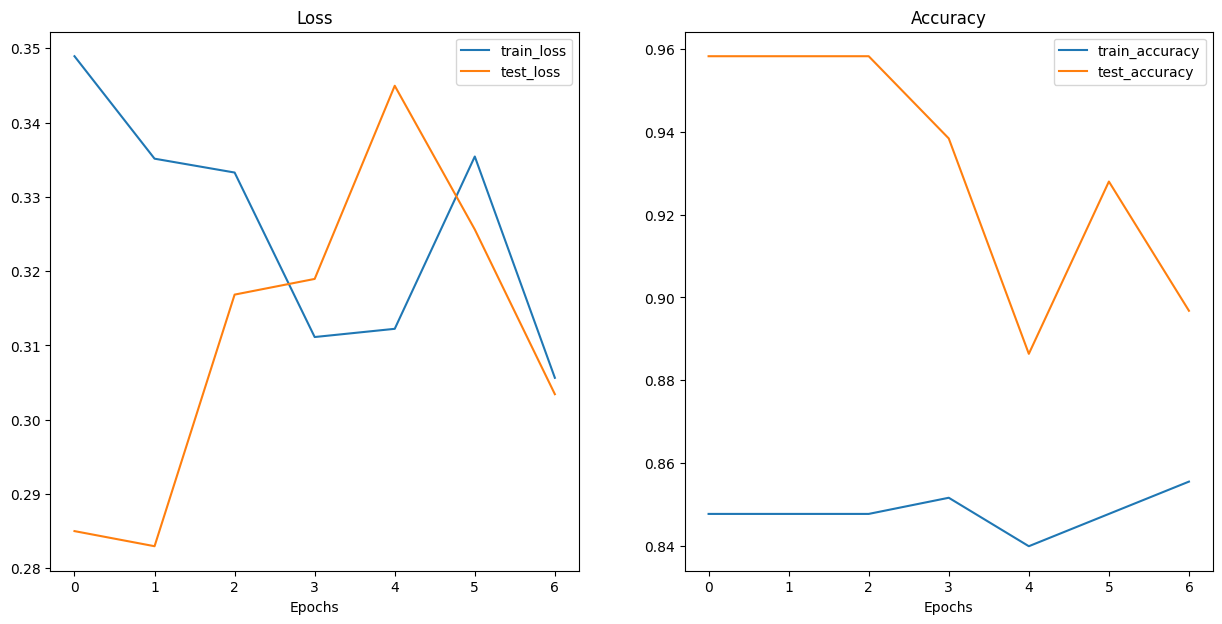

In [46]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [47]:
from typing import List, Tuple

from PIL import Image

#  Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

    # Open Image
    img = Image.open(image_path)

    # Create transformation for image
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                   std=[0.229, 0.224, 0.225])])

    # Predict on image
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width]
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_labels = target_image_pred_probs.argmax(dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis('off')

plt.show()

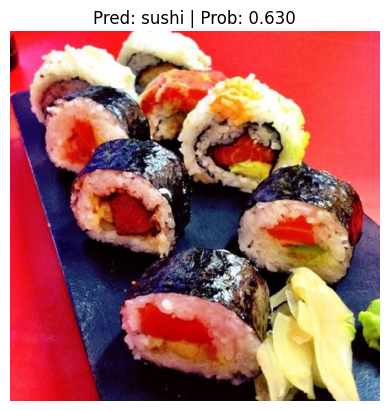

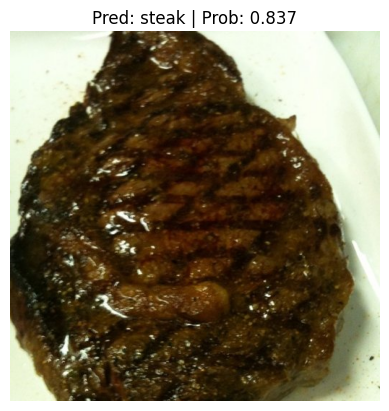

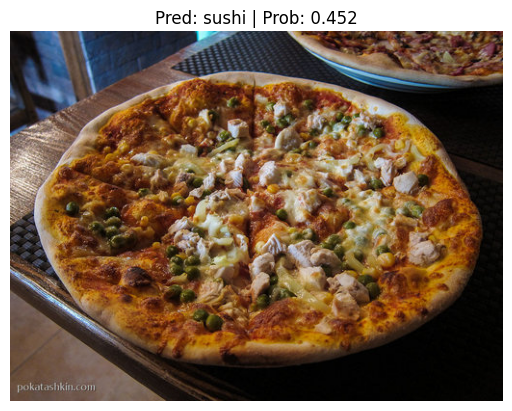

In [48]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names)

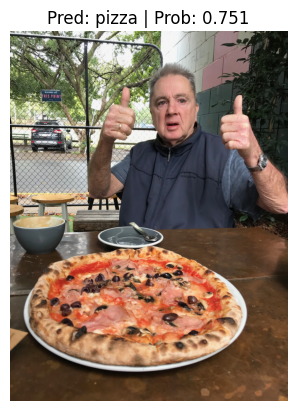

In [49]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)